# 20.5 Challenge: Model Comparison
Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. 

## Import the Data
The data was downloaded from the kaggle website(Data). It was scraped from the Goodreads API. It contains the review scores for over 13k books. See print out of the data below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('books.csv')
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,439785960,9.780440e+12,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,439358078,9.780440e+12,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,439554934,9.780440e+12,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,439554896,9.780440e+12,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9.780440e+12,eng,435,2149872,33964


## Cleaning up the Data
There are several useless columns for out model comparison such as bookID, isbn, and isbn13. These columns will be dropped. Note that there is no missing values.

In [3]:
# Drop unneeded columns.
df.drop(['bookID', 'isbn', 'isbn13'], axis=1, inplace=True)
df.head()

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,eng,652,1944099,26249
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,eng,870,1996446,27613
2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,eng,320,5629932,70390
3,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,eng,352,6267,272
4,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,eng,435,2149872,33964


In [4]:
# Count of the missing values
df.isna().sum()

title                 0
authors               0
average_rating        0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
dtype: int64

In [5]:
# See the datatypes and other info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 7 columns):
title                 13714 non-null object
authors               13714 non-null object
average_rating        13714 non-null float64
language_code         13714 non-null object
num_pages             13714 non-null int64
ratings_count         13714 non-null int64
text_reviews_count    13714 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 750.1+ KB


## Data Exploration
Several key questions come to mind when trying to understand the data:
1. Which authors have the largest numbers of books published on this list?
2. What is the distribution of the ratings? pages? rating counts?

### 1. Biggest Authors

In [6]:
# Print a list of authors with most published books
df['authors'].value_counts().head(10)

Agatha Christie                69
Stephen King                   66
Orson Scott Card               48
Rumiko Takahashi               46
P.G. Wodehouse                 42
Terry Brooks                   40
Piers Anthony                  34
Margaret Weis-Tracy Hickman    33
Dan Simmons                    32
J.R.R. Tolkien                 31
Name: authors, dtype: int64

### Distributions of Variables
Looks like all of the variables are skewed by outliers. What is interesting is that most of the average ratings are between 3 and 5. The outliers will be fixed in 'Takling Outliers Section'.

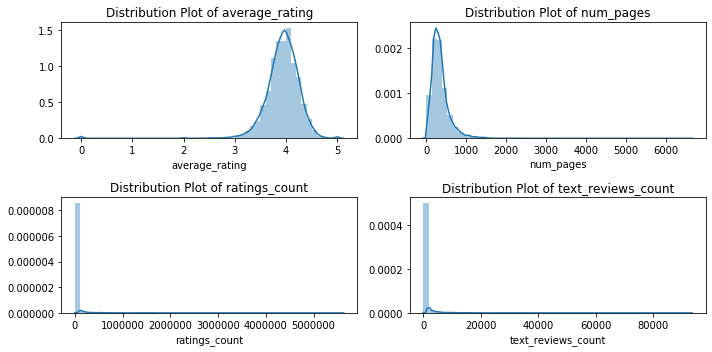

In [7]:
# Create list of all numeric variables
variables = ['average_rating', 'num_pages', 'ratings_count', 
             'text_reviews_count']

plt.figure(figsize=(10, 5))

# For each variable plot distribution plot
for i, x in enumerate(variables):
    i += 1
    plt.subplot(2, 2, i)
    sns.distplot(df[x])
    plt.title('Distribution Plot of {}'.format(x))
    
plt.tight_layout()
plt.show()

### Takling the Outliers
The outliers will be winsorized and log transformed below:

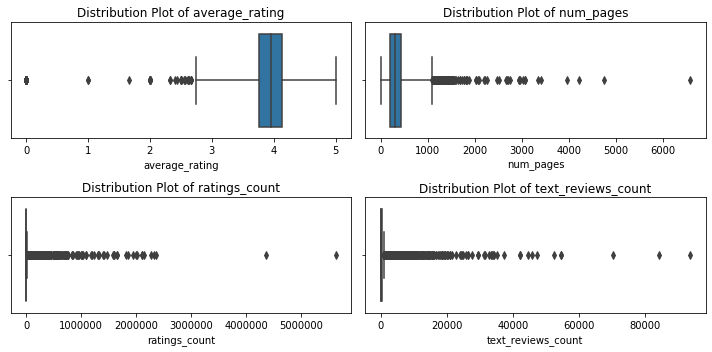

In [8]:
plt.figure(figsize=(10, 5))

# For each variable plot box plot
for i, x in enumerate(variables):
    i += 1
    plt.subplot(2, 2, i)
    sns.boxplot(df[x], whis=3)
    plt.title('Distribution Plot of {}'.format(x))
    
plt.tight_layout()
plt.show()

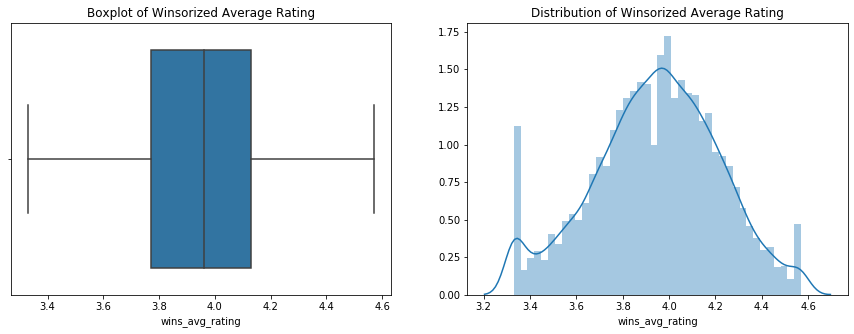

In [9]:
from scipy.stats.mstats import winsorize

# Winsorize average ratings
df['wins_avg_rating'] = winsorize(df['average_rating'], (.03, 0.01))

# Plot boxplot and distribution of new variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df['wins_avg_rating'])
plt.title('Boxplot of Winsorized Average Rating')

plt.subplot(1, 2, 2)
sns.distplot(df['wins_avg_rating'])
plt.title('Distribution of Winsorized Average Rating')

plt.show()

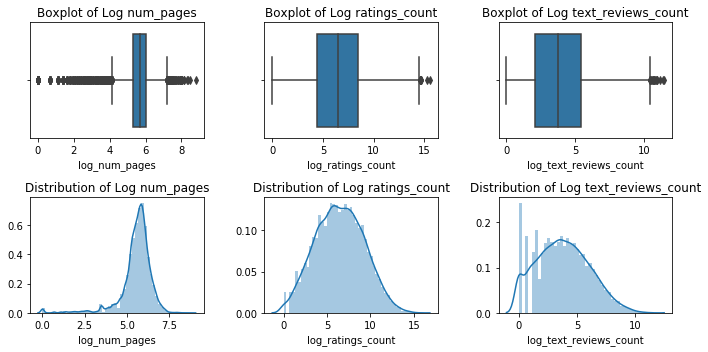

In [10]:
logs = ['num_pages', 'ratings_count', 'text_reviews_count']

plt.figure(figsize=(10, 5))

# Log transform and plot values
for i, x in enumerate(df[logs]):
    i += 1
    df['log_{}'.format(x)] = np.log1p(df[x])
    plt.subplot(2, 3, i)
    sns.boxplot(df['log_{}'.format(x)])
    plt.title('Boxplot of Log {}'.format(x))
    
    i += 3
    plt.subplot(2, 3, i)
    sns.distplot(df['log_{}'.format(x)])
    plt.title('Distribution of Log {}'.format(x))

plt.tight_layout()
plt.show()

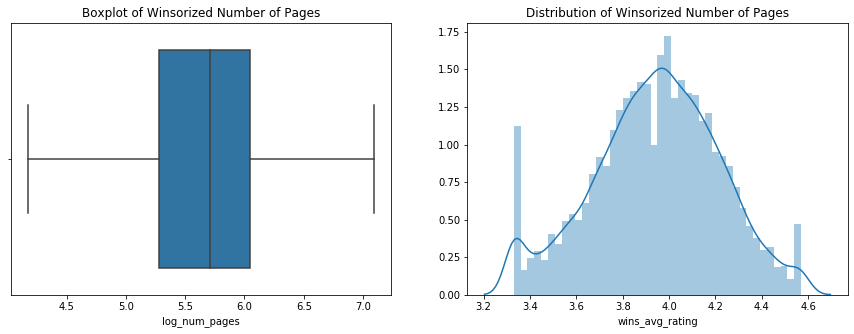

In [11]:
# Winsorize number of pages
df['log_num_pages'] = winsorize(df['log_num_pages'], (.06, 0.01))

# Plot boxplot and distribution of new variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df['log_num_pages'])
plt.title('Boxplot of Winsorized Number of Pages')

plt.subplot(1, 2, 2)
sns.distplot(df['wins_avg_rating'])
plt.title('Distribution of Winsorized Number of Pages')

plt.show()

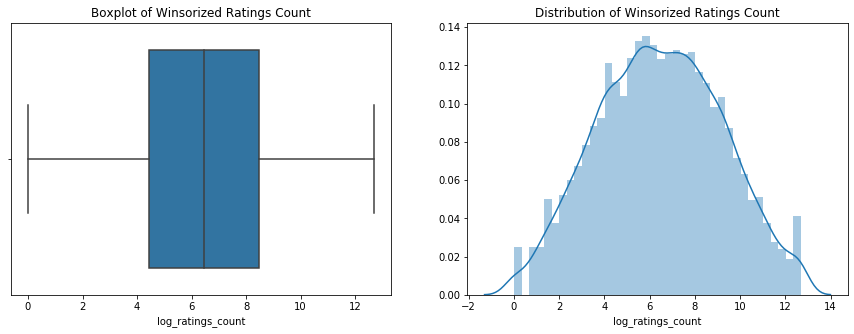

In [12]:
# Winsorize ratings count
df['log_ratings_count'] = winsorize(df['log_ratings_count'], (0, 0.01))

# Plot boxplot and distribution of new variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df['log_ratings_count'])
plt.title('Boxplot of Winsorized Ratings Count')

plt.subplot(1, 2, 2)
sns.distplot(df['log_ratings_count'])
plt.title('Distribution of Winsorized Ratings Count')

plt.show()

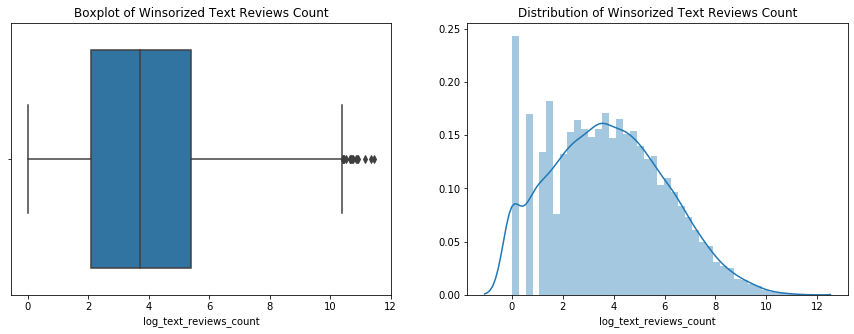

In [13]:
# Winsorize number of pages
df['log_text_reviews_count'] = winsorize(
    df['log_text_reviews_count'])

# Plot boxplot and distribution of new variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df['log_text_reviews_count'])
plt.title('Boxplot of Winsorized Text Reviews Count')

plt.subplot(1, 2, 2)
sns.distplot(df['log_text_reviews_count'])
plt.title('Distribution of Winsorized Text Reviews Count')

plt.show()

### Correlation of the Variables
Yikes, the average book rating is not at all correlated with the number of pages, ratings count, or text review count. The highest correlated value is number of pages at .12. The poor correlation of these variables will lead to poor fitting models in our modeling section.  

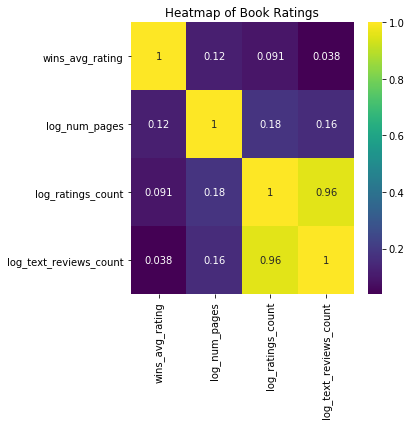

In [14]:
corr_books = df[df.columns[-4:]].corr()

plt.figure(figsize=(5,5))
sns.heatmap(corr_books, annot=True, cmap='viridis')

plt.title('Heatmap of Book Ratings')

plt.show()

## Linear Regression Model
A new classifer was create for the data. Books that are rated at or above the mean was classified as good, and books below the mean were classified as bad. A linear regression model was uesd to predict the classification of books. As expected from the poorly correlated data above, the model had a poor goodness-of-fit with an adjusted r-squared at .047. The test data did not perform much better at .0411. This lead the model to correctly predict 56% of the book reviews.

In [15]:
# Y is the target variable
Y = df['wins_avg_rating']

# X is the features
X = df[df.columns[-3:]]

# Split the data into train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

# Add constant
X_train = sm.add_constant(X_train)

# Print results of train model
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        wins_avg_rating   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     182.1
Date:                Mon, 26 Aug 2019   Prob (F-statistic):          2.92e-115
Time:                        20:19:50   Log-Likelihood:                -1116.2
No. Observations:               10971   AIC:                             2240.
Df Residuals:                   10967   BIC:                             2270.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3.5705      0.023    157.196      0.000       3.526       3.615
log_num_pages              0.0430      0.004     10.704      0.000       0.035       0.051
log_ratings_count          0.0616      0.003     18.996      0.000       0.055       0.068
log_text_reviews_count    -0.0695      0.004    -17.606      0.000      -0.077      -0.062
==============================================================================
Omnibus:                       38.778   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.201
Skew:                          -0.078   Prob(JB):                     6.17e-08
Kurtosis:                       2.780   Cond. No.                         88.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared of training set: 0.04746078601359759
-----Test set statistics-----
R-squared of test set: 0.04112028495858844
MAE: 0.21595798629807023
MSE: 0.07179418908061085
RMSE: 0.26794437684081157
MAPE: 5.557612046112701


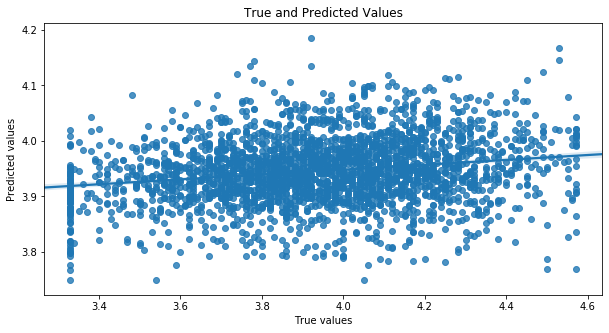

In [16]:
# Add constant to test data and predict results
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)

# Used to calculate the R-squared for comparison
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# Print comparative statistics
print("R-squared of training set: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of test set: {}".format(lrm.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, y_pred)))
print('MSE: {}'.format(mse(Y_test, y_pred)))
print('RMSE: {}'.format(rmse(Y_test, y_pred)))
print('MAPE: {}'.format(np.mean(np.abs((Y_test-y_pred)/Y_test))*100))

# Plot a Regplot of the True values vs Predicted
plt.figure(figsize=(10,5))
sns.regplot(x=Y_test, y=y_pred)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and Predicted Values")
plt.show()

### Classifying the True and Predicted Values
The accuracy of the linear regression model will compared to the KNN model. For the models to be comparable the linear regression prediction and true values need to be converted to a classified objects. In the case of our data the books will be labeled either good or bad. A book will be considered good if it scores similar to the mean or higher of the data. Anything lower will be considered bad. 

In [17]:
# Create lists if review is good or bad
review = []
pred_review = []

# Assign 1 if good 0 if bad to list
for score in Y_test:
    if score >= np.mean(df['wins_avg_rating']):
        review.append(1)
    else:
        review.append(0)

for score in y_pred:
    if score >= np.mean(df['wins_avg_rating']):
        pred_review.append(1)
    else:
        pred_review.append(0)

# Create new dataframe and add lists
score = pd.DataFrame()
score['review'] = review
score['pred_review'] = pred_review
score.head()

,review,pred_review
0,1,0
1,1,1
2,1,1
3,1,1
4,1,1


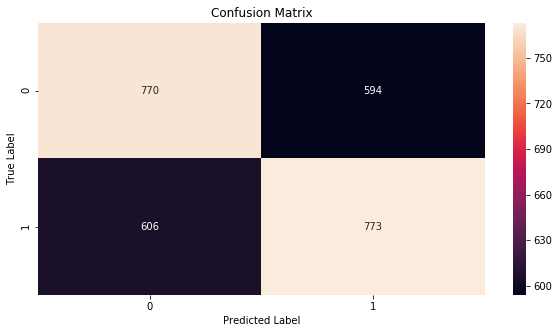

In [18]:
# Create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(score['review'], score['pred_review']), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

## KNN Model
A new classifer was create for the data. Books that are rated at or above the mean was classified as good, and books below the mean were classified as bad. The KNN model did reasonably well considering how poorly correlated the data was. The model was able to predict correctly 57% of the book review classification in the test data. 

In [19]:
# Create a new list
review = []

# Assign 1 if good 0 if bad to list
for score in df['wins_avg_rating']:
    if score >= np.mean(df['wins_avg_rating']):
        review.append(1)
    else:
        review.append(0)

In [20]:
# Y is the target variable
Y = review

# X is the features
X = df[df.columns[-3:]]

# Split the data into train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
        test_size=0.2, random_state=145)

### Selecting Ideal Perfect Neighbor
A quick for loop was created to find the better number of neighbors for the KNN. The best option was the 3rd one with 101 neighbors. 

In [21]:
# Loop through to find ideal nearest neighbor
for x in np.arange(1, 1000, 50):
    neighbors = KNeighborsClassifier(n_neighbors=x, 
                                 weights='distance', algorithm='auto')
    neighbors.fit(X_train, Y_train)
    y_pred = neighbors.predict(X_test)
    print(confusion_matrix(Y_test, y_pred))

[[689 675]
 [598 781]]
[[764 600]
 [581 798]]
[[775 589]
 [579 800]]
[[792 572]
 [589 790]]
[[814 550]
 [606 773]]
[[832 532]
 [619 760]]
[[842 522]
 [623 756]]
[[844 520]
 [634 745]]
[[845 519]
 [638 741]]
[[856 508]
 [644 735]]
[[862 502]
 [649 730]]
[[856 508]
 [651 728]]
[[869 495]
 [654 725]]
[[867 497]
 [663 716]]
[[876 488]
 [668 711]]
[[877 487]
 [672 707]]
[[877 487]
 [668 711]]
[[879 485]
 [672 707]]
[[882 482]
 [669 710]]
[[881 483]
 [674 705]]


In [22]:
# Create neighbors variable with ideal neighbors
neighbors = KNeighborsClassifier(n_neighbors=101, 
                                 weights='distance', algorithm='auto')
# Fit and predict model
neighbors.fit(X_train, Y_train)
y_pred = neighbors.predict(X_test)

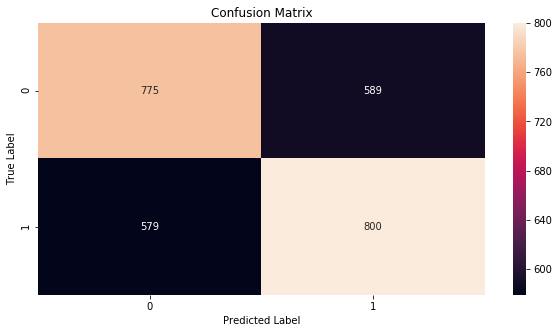

In [23]:
# Create heatmap of confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

plt.show()

## Summary and Conclusion
Overall, the models performed reasonably well considering how poorly correlated the data was. Both models performed similarily with the linear regression being 56% accurate and the KNN being 57% accurate. The linear regression had more false negatives than the KNN but only slightly. Both models are ideal in differenct circumstances. The KNN model works well with any data even if the data is non-paramatic. The data does not have to be linear. Overall I woud say the KNN model is better at handling classification modeling. The Linear Regression model is good at modeling continuous variables. The biggest issue with linear regression is that the data needs to linear. Furthermore, the data should also be normally distributed otherwise it can skew results.

It is hard to judge why the KNN model did better than the Linear Regession. One could assume that Linear Regression just performed worse because of the lack of linearity and correlation between the variables. Both models only performed between 56-57%, which in a 50-50 percent chance of guessing correctly this is not that great. More features would be needed to increase the accuracy of these models such as number of copies sold, number of weeks on NYT best seller list, or number of awards recieved. 

### References
Data - https://www.kaggle.com/jealousleopard/goodreadsbooks